# Spark SQL — Consultas un poco más complejas + gráfico


Este notebook carga `ejercicio_reviews_simple.csv`, crea una vista temporal y ejecuta consultas **Spark SQL** con:
- CTEs y funciones de texto
- Funciones de ventana (window)
- Agrupaciones con **rangos (CASE WHEN)**
- Explode para tokenizar
Al final, se genera un **gráfico** con Matplotlib (sin guardar archivos).


## 1) Crear SparkSession

In [1]:

import os, sys
from pyspark.sql import SparkSession

# Entorno recomendado (Windows/Colab): mismo Python para driver/worker
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

spark = (SparkSession.builder
         .appName("SparkSQL_Reviews_Analitica")
         .config("spark.python.use.daemon","false")
         .config("spark.python.worker.reuse","false")
         .getOrCreate())

spark


## 2) Cargar CSV y crear vista

In [2]:

csv_path = "ejercicio_reviews_simple.csv"

df = (spark.read
      .option("header", True)
      .option("inferSchema", True)
      .csv(csv_path))

df.createOrReplaceTempView("raw_reviews")

# Vista enriquecida: normaliza texto y cuenta palabras
spark.sql('''
CREATE OR REPLACE TEMP VIEW reviews AS
WITH base AS (
  SELECT
    CAST(id AS INT)        AS id,
    texto                  AS texto_raw,
    lower(trim(texto))     AS texto_norm
  FROM raw_reviews
),
with_len AS (
  SELECT
    id,
    texto_raw,
    texto_norm,
    size(split(texto_norm, ' ')) AS num_palabras
  FROM base
)
SELECT * FROM with_len
''')

spark.sql("SELECT * FROM reviews").show(truncate=False)


+---+-----------------------------------------+-----------------------------------------+------------+
|id |texto_raw                                |texto_norm                               |num_palabras|
+---+-----------------------------------------+-----------------------------------------+------------+
|1  |Muy buen servicio y atención rápida.     |muy buen servicio y atención rápida.     |6           |
|2  |Producto defectuoso, no funcionó.        |producto defectuoso, no funcionó.        |4           |
|3  |Excelente calidad, volvería a comprar.   |excelente calidad, volvería a comprar.   |5           |
|4  |Entrega lenta, pero producto aceptable.  |entrega lenta, pero producto aceptable.  |5           |
|5  |El empaque llegó dañado.                 |el empaque llegó dañado.                 |4           |
|6  |Me encantó, lo recomiendo totalmente.    |me encantó, lo recomiendo totalmente.    |5           |
|7  |No cumplió con mis expectativas.         |no cumplió con mis expecta

## 3) Top 5 reseñas más largas (window function)

In [3]:

top_largas = spark.sql('''
WITH ranked AS (
  SELECT
    id, texto_raw, num_palabras,
    ROW_NUMBER() OVER (ORDER BY num_palabras DESC, id ASC) AS rn
  FROM reviews
)
SELECT id, texto_raw, num_palabras
FROM ranked
WHERE rn <= 5
ORDER BY num_palabras DESC, id ASC
''')
top_largas.show(truncate=False)


+---+---------------------------------------+------------+
|id |texto_raw                              |num_palabras|
+---+---------------------------------------+------------+
|1  |Muy buen servicio y atención rápida.   |6           |
|8  |Buen diseño y fácil de usar.           |6           |
|9  |Precio demasiado alto para la calidad. |6           |
|3  |Excelente calidad, volvería a comprar. |5           |
|4  |Entrega lenta, pero producto aceptable.|5           |
+---+---------------------------------------+------------+



## 4) Distribución por rangos de longitud (CASE WHEN)

In [4]:

dist_rangos = spark.sql('''
SELECT
  CASE
    WHEN num_palabras BETWEEN 0 AND 3 THEN '0-3'
    WHEN num_palabras BETWEEN 4 AND 6 THEN '4-6'
    WHEN num_palabras BETWEEN 7 AND 10 THEN '7-10'
    ELSE '11+'
  END AS rango,
  COUNT(*) AS total
FROM reviews
GROUP BY 1
ORDER BY
  CASE rango WHEN '0-3' THEN 1 WHEN '4-6' THEN 2 WHEN '7-10' THEN 3 ELSE 4 END
''')
dist_rangos.show()


+-----+-----+
|rango|total|
+-----+-----+
|  4-6|   10|
+-----+-----+



## 5) Promedio de palabras por polaridad simple (keywords)

In [5]:

prom_polaridad = spark.sql('''
WITH flags AS (
  SELECT
    *,
    CASE
      WHEN texto_norm LIKE '%excelente%' OR texto_norm LIKE '%bueno%' OR texto_norm LIKE '%buen%' THEN 'positivo'
      WHEN texto_norm LIKE '%malo%' OR texto_norm LIKE '%defectuoso%' OR texto_norm LIKE '%no funcion%' THEN 'negativo'
      ELSE 'neutro'
    END AS polaridad
  FROM reviews
)
SELECT polaridad, AVG(num_palabras) AS promedio_palabras, COUNT(*) AS n
FROM flags
GROUP BY polaridad
ORDER BY n DESC
''')
prom_polaridad.show(truncate=False)


+---------+-----------------+---+
|polaridad|promedio_palabras|n  |
+---------+-----------------+---+
|neutro   |5.0              |6  |
|positivo |5.666666666666667|3  |
|negativo |4.0              |1  |
+---------+-----------------+---+



## 6) Top 10 palabras más frecuentes (filtrando stopwords)

In [6]:

stop = ["y","de","la","el","en","para","lo","las","los","un","una","muy","no","con","por","que","mi","se"]
stop_list = "(" + ",".join(["'" + s + "'" for s in stop]) + ")"

query_top_tokens = f'''
WITH toks AS (
  SELECT
    id,
    explode(split(texto_norm, ' ')) AS token
  FROM reviews
),
clean AS (
  SELECT
    id,
    regexp_replace(token, '[^a-záéíóúñ0-9]', '') AS tok
  FROM toks
),
filtered AS (
  SELECT tok FROM clean
  WHERE tok <> '' AND LENGTH(tok) >= 3 AND tok NOT IN {stop_list}
)
SELECT tok AS palabra, COUNT(*) AS freq
FROM filtered
GROUP BY tok
ORDER BY freq DESC, palabra ASC
LIMIT 10
'''
top_tokens = spark.sql(query_top_tokens)
top_tokens.show(truncate=False)


+------------+----+
|palabra     |freq|
+------------+----+
|buen        |2   |
|calidad     |2   |
|expectativas|2   |
|mis         |2   |
|producto    |2   |
|aceptable   |1   |
|alto        |1   |
|atención    |1   |
|cinco       |1   |
|comprar     |1   |
+------------+----+



## 7) Gráfico: distribución por rangos de longitud

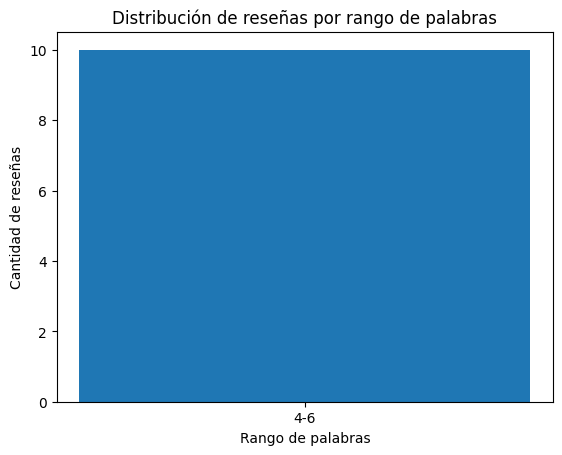

In [7]:

# Convertimos a Pandas y graficamos con Matplotlib (sin estilos ni colores específicos)
import matplotlib.pyplot as plt

pdf = dist_rangos.toPandas()

plt.figure()
plt.bar(pdf["rango"], pdf["total"])
plt.title("Distribución de reseñas por rango de palabras")
plt.xlabel("Rango de palabras")
plt.ylabel("Cantidad de reseñas")
plt.show()
